### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [1016]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


SETTINGS

In [1017]:
APPLY_LOW_PASS_FILTER = True
LSTM_READY = False
FEATURE_SET = 1
subject = '004'
run = 1

Now load the BIDS dataset

In [1018]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [1019]:
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.json'>


Load information about channels

In [1020]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LAM_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
2,LAM_03,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
3,LAM_04,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
4,LAM_05,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
5,LAM_06,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RIGHT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
133,RIGHT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
134,RIGHT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [1021]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,375.780287,12024969,1.494031,ENCODE,1.0
1,378.278411,12104909,1.495906,ENCODE,1.0
2,380.786316,12185162,1.488000,ENCODE,1.0
3,383.279534,12264945,1.494781,ENCODE,1.0
4,385.780283,12344969,1.494031,ENCODE,1.0
...,...,...,...,...,...
175,1924.491728,61583735,1.495061,ENCODE,15.0
176,1926.991914,61663741,1.494906,ENCODE,15.0
177,1929.494851,61743835,1.491968,ENCODE,15.0
178,1931.994350,61823819,1.492468,ENCODE,15.0


Now load the raw data

In [1022]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-01_ieeg.mefd


[{'name': 'LAM_01',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_02',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_03',
  'fsamp': array([32000.]),
  'nsamp': array([65920218], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1553940917170848], dtype=int64),
  'end_time': array([1553942977177662], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')}

Now load the data from encoding events

In [1023]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1553940917170848
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,375.780287,12024969,1.494031,ENCODE,1.0,375780287.0,1553941292951135
1,378.278411,12104909,1.495906,ENCODE,1.0,378278411.0,1553941295449259
2,380.786316,12185162,1.488000,ENCODE,1.0,380786316.0,1553941297957164
3,383.279534,12264945,1.494781,ENCODE,1.0,383279534.0,1553941300450382
4,385.780283,12344969,1.494031,ENCODE,1.0,385780283.0,1553941302951131


In [1024]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
# −200ms to 0ms from the onset and from 1000ms to 1400ms
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 400000, e + 900000]))
data_events = np.array(data_events)
data_events.shape

(180, 2, 225)

In [1025]:
print(data_events[0])

[[2.51177600e+08 2.52238000e+08 2.48923799e+08 2.48870999e+08
  2.49504000e+08 2.53387400e+08 2.48895200e+08 2.52428400e+08
  2.51983200e+08 2.48171000e+08 2.43966000e+08 2.44111999e+08
  2.44111999e+08 2.44111999e+08 2.43942400e+08 2.43321600e+08
  2.39275999e+08 2.40715800e+08 2.40842100e+08 2.41444800e+08
  2.35046000e+08 2.37269000e+08 2.41702500e+08 2.41147999e+08
  2.34028800e+08 2.32010200e+08 2.33168400e+08 2.32212499e+08
  2.33549700e+08 2.33549700e+08 2.29532400e+08 2.42818200e+08
  2.35805199e+08 2.29795200e+08 2.33387400e+08 2.37345299e+08
  2.37345299e+08 2.33693599e+08 2.25373500e+08 2.25373500e+08
  2.29136700e+08 2.30383200e+08 2.29290600e+08 2.32537500e+08
  2.32862500e+08 2.30907600e+08 2.24490099e+08 2.31091200e+08
  2.30340600e+08 2.29471199e+08 2.25938700e+08 2.25938700e+08
  2.26381400e+08 2.26098600e+08 2.29250400e+08 2.25373500e+08
  2.21321800e+08 2.24525700e+08 2.33722300e+08 2.29958399e+08
  2.30283199e+08 2.30283199e+08 2.30283199e+08 2.28620000e+08
  2.2959

## Artefacts cutout

In [1026]:
def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [1027]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        missing_values_idx = []
        for sample_idx, sample in enumerate(channel):
            if np.isnan(sample):
                missing_values_idx.append(sample_idx)
        print(missing_values_idx)
        for missing in missing_values_idx[::-1]:
            if missing >= 5:
                for i in range(5):
                    data_events[s_idx][ch_idx][missing-i] = np.nan
            if missing <= 221:
                for i in range(3):
                    data_events[s_idx][ch_idx][missing+i] = np.nan

[]
[]
[]
[]
[162, 163]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[159, 160, 161, 162, 163, 164, 167, 168, 169, 170, 171, 172, 174, 175]
[158, 159, 160, 161, 163, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 217]
[190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 217]
[]
[]
[]
[]
[]
[]
[143, 148, 152, 153, 156, 159]
[145, 146, 147, 148, 149, 150, 151, 152, 153]
[]
[]
[206]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[153, 154, 155, 156, 157, 159, 160, 161, 164, 167, 169, 177, 178, 179]
[154, 159, 160, 161, 164, 165, 169, 177, 178, 179]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[131, 134, 135, 136,

## Apply linear interpolation if values are missing

In [1028]:
how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [2][0]
[2.51410499e+08 2.51410499e+08 2.51410499e+08 2.51410499e+08
 2.51410499e+08 2.56329000e+08 2.59178400e+08 2.61403800e+08
 2.51008000e+08 2.54462399e+08 2.54462399e+08 2.54610000e+08
 2.52938400e+08 2.59749000e+08 2.61295100e+08 2.58215400e+08
 2.55398400e+08 2.56885200e+08 2.56885200e+08 2.56885200e+08
 2.59828400e+08 2.57423400e+08 2.57299200e+08 2.68052800e+08
 2.58512800e+08 2.61288000e+08 2.60414200e+08 2.65286200e+08
 2.61403000e+08 2.55740600e+08 2.54487100e+08 2.58438299e+08
 2.67719999e+08 2.66219999e+08 2.66067000e+08 2.66547100e+08
 2.61936000e+08 2.69079000e+08 2.68133999e+08 2.68790600e+08
 2.62268000e+08 2.62980900e+08 2.61117000e+08 2.62331300e+08
 2.56414400e+08 2.55944000e+08 2.63177599e+08 2.62874399e+08
 2.62441000e+08 2.62007399e+08 2.64018500e+08 2.64654000e+08
 2.60604299e+08 2.63651200e+08 2.58462000e+08 2.61948800e+08
 2.60992500e+08 2.63347200e+08 2.63499600e+08 2.6528460

## Connect windows to continuous signal across channels

In [1029]:
channel_1_raw = []
channel_2_raw = []
for s_idx, sequence in enumerate(data_events):
    for sample in data_events[s_idx][0]:
        channel_1_raw.append(sample)
    for sample in data_events[s_idx][1]:
        channel_2_raw.append(sample)
channel_1_raw = np.array(channel_1_raw)
channel_2_raw = np.array(channel_2_raw)
channel_1_raw.shape

(40500,)

### Apply z-score normalization

In [1030]:
mean = np.mean(channel_1_raw)
std = np.std(channel_1_raw)
data_normalized = (channel_1_raw - mean) / std
channel_1_raw = data_normalized

mean = np.mean(channel_2_raw)
std = np.std(channel_2_raw)
data_normalized = (channel_2_raw - mean) / std
channel_2_raw = data_normalized

### Split again into windows

In [1031]:
def split_list(lst, n):
    """Split the list, lst, into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [1032]:
samples_in_window = 225
chunks_1 = split_list(channel_1_raw, samples_in_window)
chunks_2 = split_list(channel_2_raw, samples_in_window)
print(len(chunks_1))

180


In [1033]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if ch_idx == 0:
            data_events[s_idx][ch_idx] = chunks_1[s_idx]
        elif ch_idx == 1:
            data_events[s_idx][ch_idx] = chunks_2[s_idx]
data_events = np.array(data_events)
print(data_events.shape)

(180, 2, 225)


In [1034]:
print(data_events[0][0][0])

-0.27479227412046864


## Plot the window

In [1035]:
def plot_channels(data):
    # assuming 'data' is your list
    data = np.array(data)  # convert list to numpy array
    print(data.shape)
    time = np.arange(0, data.shape[1])  # creating a time vector

    # plotting the data
    plt.figure(figsize=(10,6))  # creating a new figure with specified size
    print(data[0])
    # plot for channel 1
    plt.subplot(2, 1, 1)  # creating the first subplot in a 2x1 grid
    plt.plot(time, data[0], color='blue')  # plotting the data for the first channel
    plt.title('Channel 1')  # setting the title of the first subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    # plot for channel 2
    plt.subplot(2, 1, 2)  # creating the second subplot in a 2x1 grid
    plt.plot(time, data[1], color='red')  # plotting the data for the second channel
    plt.title('Channel 2')  # setting the title of the second subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    plt.tight_layout()  # adjusting the layout so everything fits
    plt.show()  # displaying the figure

(2, 225)
[-0.27479227 -0.25907747 -0.30819292 -0.3089754  -0.29959452 -0.24204371
 -0.30861675 -0.2562558  -0.26285353 -0.31934917 -0.381666   -0.37950234
 -0.37950234 -0.37950234 -0.38201575 -0.39121581 -0.45117039 -0.42983298
 -0.42796125 -0.41902942 -0.5138577  -0.48091351 -0.41521038 -0.42342792
 -0.52893229 -0.55884733 -0.54168316 -0.55584932 -0.53603241 -0.53603241
 -0.59556758 -0.39867605 -0.5026066  -0.59167296 -0.53843765 -0.47978278
 -0.47978278 -0.53389987 -0.65720122 -0.65720122 -0.60143173 -0.58295898
 -0.59915098 -0.55103291 -0.54621651 -0.57518753 -0.67029295 -0.57246664
 -0.5835903  -0.59647456 -0.64882512 -0.64882512 -0.64226444 -0.64645545
 -0.59974673 -0.65720122 -0.71724618 -0.66976536 -0.53347453 -0.5892544
 -0.58444097 -0.58444097 -0.58444097 -0.60908907 -0.59465172 -0.55190875
 -0.58761533 -0.58311014 -0.58072269 -0.56777176 -0.52107934 -0.50502665
 -0.53445411 -0.56489525 -0.56489525 -0.5627805  -0.49921584 -0.48999948
 -0.49348061 -0.5079476  -0.56777176 -0.497

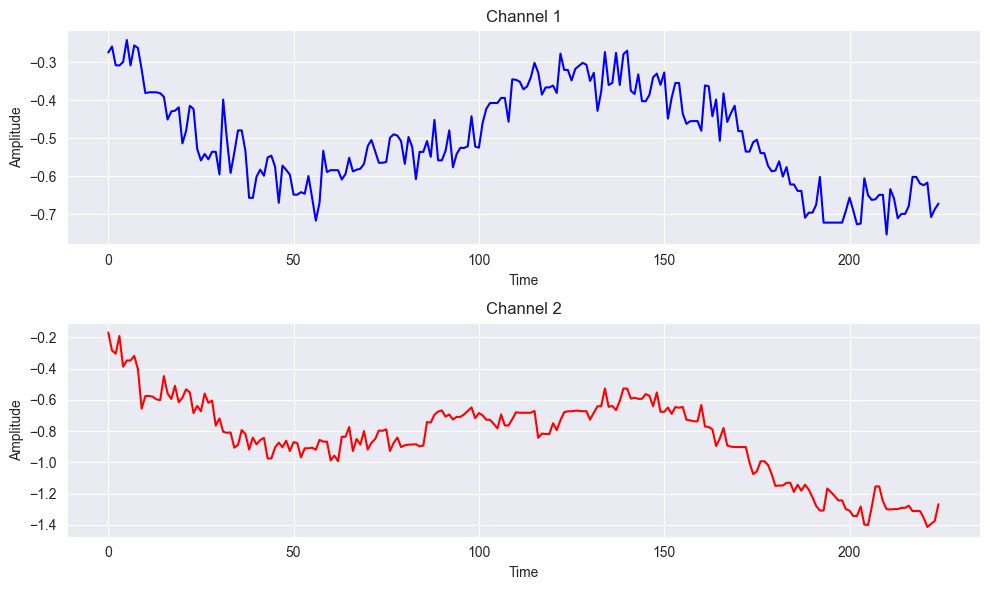

In [1036]:
plot_channels(data_events[0])

## Define and apply butterworth filter

In [1037]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 20.0    # desired cutoff frequency of the filter, Hz


In [1038]:
if APPLY_LOW_PASS_FILTER:
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            y = butter_lowpass_filter(channel, cutoff, fs, order)
            data_events[s_idx][ch_idx] = y

(2, 225)
[-0.27481055 -0.28688657 -0.29451894 -0.29457522 -0.28724703 -0.27700728
 -0.27092396 -0.27541826 -0.29297337 -0.32001917 -0.34822588 -0.3696787
 -0.38193052 -0.38851635 -0.39510304 -0.40508473 -0.41806606 -0.4315612
 -0.44315389 -0.45096333 -0.45406329 -0.4547638  -0.45960293 -0.4748985
 -0.50021904 -0.52759786 -0.54749448 -0.55477972 -0.54998678 -0.53741348
 -0.52318372 -0.51305559 -0.50900845 -0.50837317 -0.50912375 -0.51533224
 -0.53383393 -0.56470298 -0.5972861  -0.6172792  -0.61761105 -0.60263992
 -0.58368084 -0.57156504 -0.57116984 -0.57988484 -0.59103281 -0.60006679
 -0.60746862 -0.61566528 -0.62489837 -0.63337442 -0.64033445 -0.64707876
 -0.654099   -0.65775281 -0.65176797 -0.63380014 -0.60970369 -0.58957436
 -0.57987368 -0.57995981 -0.58464247 -0.588673   -0.58964173 -0.58783253
 -0.5837387  -0.57635093 -0.56460944 -0.55037801 -0.53899596 -0.53567262
 -0.54051614 -0.54724198 -0.54755877 -0.53771295 -0.52154013 -0.50752615
 -0.5026584  -0.50835837 -0.52117493 -0.53597

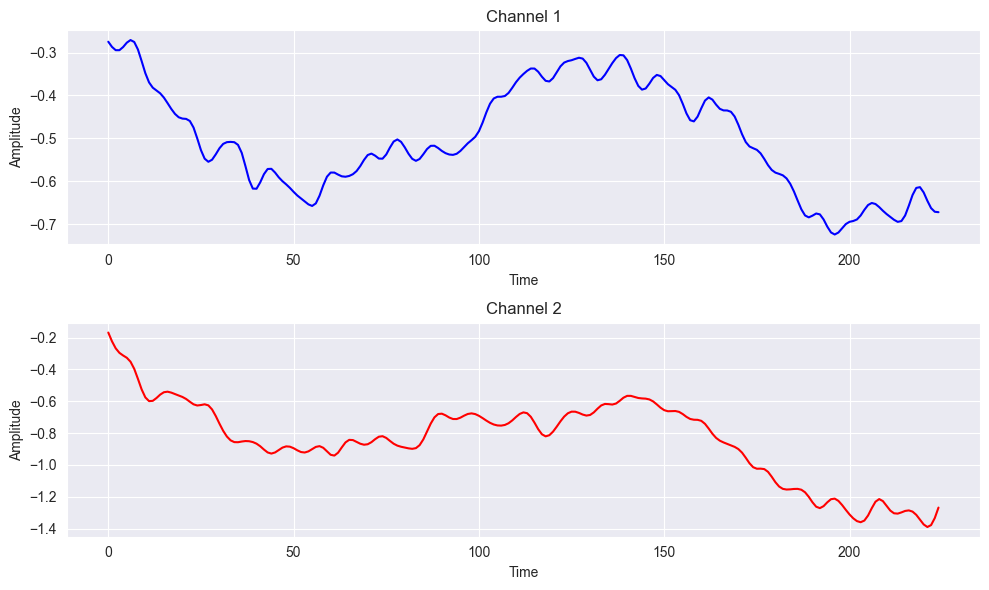

In [1039]:
plot_channels(data_events[0])

## Feature extraction

### Feature set 1
https://www.hindawi.com/journals/cin/2020/2909267/

In [1040]:
import mne

if FEATURE_SET == 1:
    sfreq = 150  # replace with your sampling frequency
    # delta: 2.5-5 Hz, theta: 4–9 Hz, alpha: 9–16 Hz, beta: 16–25 Hz,
    freqs = [9., 16., 25., 40.]  # define the range of frequency bands
    # freqs = [5.]
    print(freqs)
    n_cycles = 7.0

    # perform Morlet Wavelet transform
    power = mne.time_frequency.tfr_array_morlet(data_events, sfreq, freqs, n_cycles=n_cycles)
    power = np.mean(power, axis=1)

    # n_samples * n_channels * n_frequencies * n_times
    # power = 10 * np.log10(power)
# power.shape

[9.0, 16.0, 25.0, 40.0]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


### Feature set 2 - 6 features
https://www.mdpi.com/2227-9032/11/3/322

In [1041]:
from scipy.stats import skew, kurtosis, variation


if FEATURE_SET == 2 and not LSTM_READY:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            q1 = np.percentile(eeg_data, 25)
            q2 = np.percentile(eeg_data, 50)
            q3 = np.percentile(eeg_data, 75)
            min_signal = np.min(eeg_data)
            max_signal = np.max(eeg_data)
            # variance = variation(eeg_data)
            # skewness = skew(eeg_data)

            features = [mean, q1, q2, q3, min_signal, max_signal]

            # print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

### Feature set 3 - 4 features
https://www.hindawi.com/journals/cin/2020/2909267/

In [1042]:

if FEATURE_SET == 3:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            variance = variation(eeg_data)
            skewness = skew(eeg_data)
            # kurtosis = kurtosis(eeg_data)

            features = [mean, variance, skewness]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

## Reshape to dataframe

In [1043]:
power.shape

(180, 4, 225)

In [1044]:

power_magnitude = np.abs(power)
# convert to a decibel scale, which is often done for power spectral densities:
power_db = 10 * np.log10(power_magnitude)
arr = np.array(power_db)

# Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

df = pd.DataFrame(arr_reshaped)

# Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 900)


In [1045]:
# arr = np.array(data_events)
#
#     # Reshape the array to the required shape (180, 450)
# arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension
#
# df = pd.DataFrame(arr_reshaped)
#
#     # Now df is a DataFrame with shape (180, 450)
# print(df.shape)

In [1046]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,-10.068111,-10.168464,-10.284692,-10.416757,-10.564575,-10.728012,-10.906863,-11.100843,-11.309567,-11.532531,...,-16.309320,-13.988471,-11.940930,-10.151858,-8.616190,-7.333102,-6.303188,-5.527281,-5.006204,-4.740724
1,-3.079432,-3.105338,-3.145047,-3.198622,-3.266131,-3.347645,-3.443243,-3.553007,-3.677029,-3.815406,...,-18.269422,-15.901445,-13.818940,-12.008289,-10.462078,-9.176429,-8.149114,-7.378675,-6.864281,-6.605622
2,-6.059238,-6.100880,-6.157827,-6.230322,-6.318635,-6.423068,-6.543956,-6.681673,-6.836636,-7.009305,...,-18.887741,-16.574491,-14.519438,-12.724280,-11.187693,-9.908325,-8.885440,-8.118799,-7.608471,-7.354640
3,-0.051419,-0.057451,-0.075898,-0.106721,-0.149879,-0.205323,-0.273004,-0.352866,-0.444848,-0.548885,...,-17.715274,-15.435779,-13.393199,-11.600445,-10.062608,-8.781876,-7.758979,-6.993821,-6.486039,-6.235287
4,-11.240469,-11.305550,-11.388228,-11.488611,-11.606680,-11.742213,-11.894688,-12.063142,-12.245973,-12.440691,...,-17.365989,-15.004700,-12.926241,-11.122476,-9.586429,-8.313047,-7.298901,-6.541754,-6.040315,-5.793997


In [1047]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)